<a href="https://colab.research.google.com/github/nitaymayo/My_Portfolio/blob/main/AI/Tensorflow/Time_Series_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Forecasting using Tensorflow

Tensorflow models trained and tested on the bit stock prices dataset

In [ ]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
! wget https://raw.githubusercontent.com/nitaymayo/my_repo/main/helper_functions.py
from helper_functions import *

In [ ]:
# Getiing the data
! wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

/bin/bash: /home/nitay/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
--2023-01-31 13:04:55--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  1.10MB/s    in 0.2s    

2023-01-31 13:04:55 (1.10 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



In [ ]:
# Reading the data with pandas module
bit_data = pd.read_csv("BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv",
                       parse_dates=["Date"],
                       index_col=["Date"])

In [ ]:
bit_data.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [ ]:
# Inspecting the data
bit_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


<AxesSubplot: xlabel='Date'>

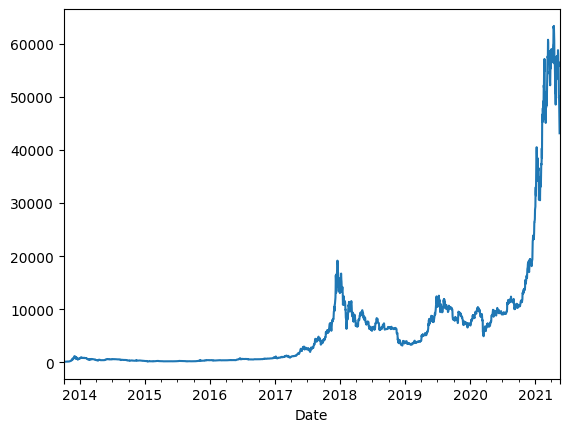

In [ ]:
bit_data["Closing Price (USD)"].plot()

In [ ]:
# Splitting the data to timesteps and prices

bitcoin_prices = pd.DataFrame(bit_data["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})

bitcoin_prices[:10]

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866
2013-10-06,120.65533
2013-10-07,121.79500
2013-10-08,123.03300
2013-10-09,124.04900


In [ ]:
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [ ]:
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

timesteps.shape, prices.shape

((2787,), (2787,))

In [ ]:
# Splitting the data to train test splits

split_size = int(0.8 * len(bit_data))

# Creating the train split
x_train, y_train = timesteps[:split_size], prices[:split_size]

# Creating the test split
x_test, y_test = timesteps[split_size:], prices[split_size:] 

## Building models

Builidng the following models:
0. Naive model (baseline)
1. Dense model	horizon=1	window=7	
2. Same as 1	horizon=1	window=30
3. Same as 1	horizon=7	window=30
4. Conv1D	horizon=1	window=7
5. LSTM	horizon=1	window=7
6. Same as 1 (with multivariate data)	horizon=1	window=7	Block reward size
7. N-BEATs Algorithm	horizon=1	window=7
8. Ensemble (multiple models optimized on different loss functions)	horizon=1	window=7	
9. Future prediction model (model to predict future values)	horizon=1	window=7	
10. Same as 1 with turkey data

### Model 0 Baseline: Naive forcast

by the following formula:

$$\hat{y}_t=y_{t-1}$$

In [ ]:
# Creating the naive forcast

naive_forcast = y_test[:-1]
naive_forcast[1]

8794.3586445233

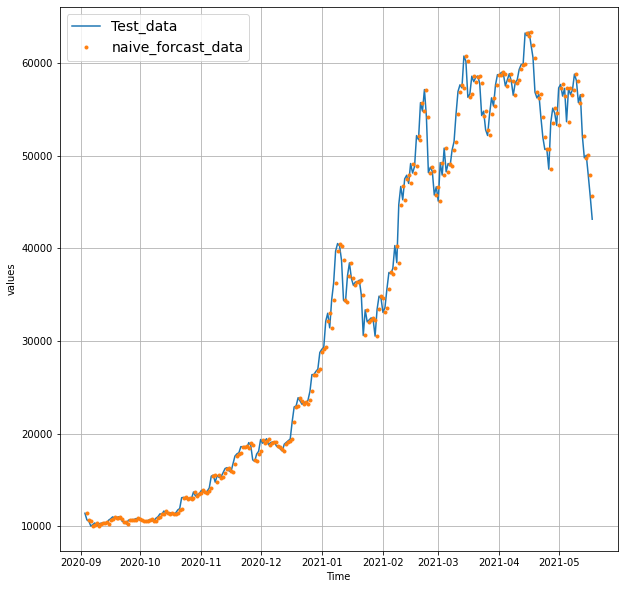

In [ ]:
# Plotting the naive forcasts
plt.figure(figsize=(10,10))
# plot_time_series(x_train, y_train, label="Train_data")
plot_time_series(x_test, y_test, start=300, label="Test_data", format="-")
plot_time_series(x_test[1:], naive_forcast, start=300, label="naive_forcast_data")

In [ ]:
# Creating a MASE parameter function to evaluate future models
def MASE_parameter(y_true, y_pred):
  """
  Returns a MASE paramter
  if the returned value >1 that the model is better then the naive, else worse than the naive forcast
  """
  mae = tf.reduce_mean(tf.abs(y_true-y_pred))
  mae_naive = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))
  return mae / mae_naive

In [ ]:
MASE_parameter(y_test[1:], naive_forcast).numpy()

0.9995699939182624

In [ ]:
# Creating a function that returns an evaluation dictionary
def regression_evaluation(y_true, y_pred):
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = MASE_parameter(y_true, y_pred)


  # Account for diffrenet horizons sizes
  if mae.ndim > 0:
    print("Multi dim input")
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [ ]:
naive_results = regression_evaluation(y_test[1:], naive_forcast)

naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.5165248,
 'mase': 0.99957}

### Preparing data

In [ ]:
# Formatting the data as windows and horizons
HORIZON = 1
WINDOW_SIZE = 7

def get_labelled_windows(x, horizon=HORIZON):
  return x[:, :-horizon], x[:, -horizon:]

In [ ]:
# Function to create windows and horizons data
def make_windows(x, window_size, horizon):
  """
  Function to create windows and horizons data set
  """

  # Creating a window to shift across the data
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)

  # Creating the windows + horizons indexes array by shifting the window_step array across every index from 0 to len(x)-(window_size+horizon-1)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T

  # Index on x with the window_indexes array
  windowed_array = x[window_indexes]

  # Seperating windows and labels
  windows, labels = get_labelled_windows(windowed_array, horizon)

  return windows, labels

In [ ]:
# turning the windows to train and test split
def make_time_train_test_split(windows, labels, test_split=0.2):
  """
  make the whole data into a train and test splits

  Returns:
  The following order:
   x_train, x_test, y_train, y_test 
  """

  split_size = int(len(windows) * (1-test_split))

  x_train = windows[:split_size]
  y_train = labels[:split_size]
  x_test = windows[split_size:]
  y_test = labels[split_size:]

  return x_train, x_test, y_train, y_test 

In [ ]:
# Function to preprocess the data
def preprocess_data(x, y, batch_size=128):
  x = tf.cast(x, tf.float32)
  y = tf.cast(y, tf.float32)

  x = tf.data.Dataset.from_tensor_slices(x)
  y = tf.data.Dataset.from_tensor_slices(y)

  ds = tf.data.Dataset.zip((x, y))
  return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

### Creating checkpoint callback

to save the best model in each training

In [ ]:
import os

# Funcrtion to create checkpoint callback for the models
def create_model_checkpoint(model_name, save_dir="models_experiment", set_verbose=2):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_dir, model_name),
                                            verbose=set_verbose,
                                            save_best_only=True)

### Model 1: Dense Model (W=7, H=1)

In [ ]:
# Preparing the data
full_windows, full_labels = make_windows(prices, 7, 1)

len(full_windows), len(full_labels)

(2780, 2780)

In [ ]:
# Splitting the data
x_train, x_test, y_train, y_test = make_time_train_test_split(full_windows, full_labels)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((2224, 7), (2224, 1), (556, 7), (556, 1))

In [ ]:
from tensorflow.keras import layers

model_1 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(1, activation="linear")
], name="model_1_dense")

model_1.compile(loss="mae",
                optimizer="Adam",
                metrics=["mae", "mse"])

model_1_history = model_1.fit(x_train,
                              y_train,
                              epochs=100,
                              verbose=1,
                              batch_size=128,
                              validation_data=(x_test, y_test),
                              callbacks=[create_model_checkpoint(model_1.name)])

Epoch 1/100
17/18 [===========================>..] - ETA: 0s - loss: 892.5579 - mae: 892.5579 - mse: 2944224.5000   
Epoch 1: val_loss improved from inf to 2601.04077, saving model to models_experiment/model_1_dense
18/18 [==============================] - 2s 51ms/step - loss: 884.1020 - mae: 884.1020 - mse: 2897712.0000 - val_loss: 2601.0408 - val_mae: 2601.0408 - val_mse: 16493631.0000
Epoch 2/100
 1/18 [>.............................] - ETA: 0s - loss: 452.7934 - mae: 452.7934 - mse: 568897.0625
Epoch 2: val_loss improved from 2601.04077 to 1164.86621, saving model to models_experiment/model_1_dense
18/18 [==============================] - 1s 31ms/step - loss: 277.7174 - mae: 277.7174 - mse: 315708.0000 - val_loss: 1164.8662 - val_mae: 1164.8662 - val_mse: 4521403.0000
Epoch 3/100
 1/18 [>.............................] - ETA: 0s - loss: 208.9985 - mae: 208.9985 - mse: 186498.4688
Epoch 3: val_loss improved from 1164.86621 to 1117.90662, saving model to models_experiment/model_1_dens

In [ ]:
# Create a function to fit, load, evaluate and plot a given model
import tensorflow_datasets as tfds
def run_model_experiment(model, train_ds, test_ds, n_epochs, set_callbacks=[], set_verbose=0):
  """
  A function that will fit a model, then will load the best preforming checkpoint, evaluate the model and will plot its predictions againts the test data

  Args:
  model: the checked model
  train_ds, test_ds: data sets of train and test data
  n_epochs: number of epochs to fit the model
  callbacks: add callbacks to the model training, a checkpoint callback is deafult in the training

  Returns:
  best_model = returns the best model
  history: model fitting hgistory object
  evaluation dictionary: an evaluation dictionary according to the regression_evaluation method
  """
  set_callbacks.append(create_model_checkpoint(model.name))
  model_history = model.fit(train_ds,
                            epochs=n_epochs,
                            validation_data=test_ds,
                            callbacks=set_callbacks,
                            verbose=set_verbose)
  
  best_model = tf.keras.models.load_model(f"/content/models_experiment/{model.name}")

  model_preds = tf.squeeze(best_model.predict(test_ds))

  print("preds labels: ", model_preds.shape, model_preds[:4])

  # get the test labels
  # test_labels = np.asarray(list(map(lambda x: x[1], tfds.as_numpy(test_ds.unbatch()))))
  test_labels = []
  for x in iter(tfds.as_numpy(train_ds.unbatch())):
    test_labels.append(tf.squeeze(x[1]).numpy())

  # test_labels = tf.squeeze(test_labels)

  # print("Test labels: ", test_labels.shape, test_labels[:4])


  model_results = regression_evaluation(test_labels, model_preds)

  print("Model results:\n", model_results)

  plt.figure(figsize=(10,10))
  plot_time_series(timesteps[-len(test_labels):], model_preds, label=model.name)
  plot_time_series(timesteps[-len(test_labels):], test_labels, label="ground-truth", format="-")

  return best_model, model_history, model_results

In [ ]:
# load the best model
model_1 = tf.keras.models.load_model("/content/models_experiment/model_1_dense")

model_1.evaluate(x_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 567.3488 - mae: 567.3488 - mse: 1166999.2500


[567.3487548828125, 567.3487548828125, 1166999.25]

In [ ]:
# Creating prediction array
model_1_preds = tf.squeeze(model_1.predict(x_test))

model_1_preds[:5], model_1_preds.shape

18/18 [==============================] - 0s 2ms/step


(<tf.Tensor: shape=(5,), dtype=float32, numpy=array([8831.881, 8740.21 , 9000.423, 8780.19 , 8712.199], dtype=float32)>,
 TensorShape([556]))

In [ ]:
# Getting the evaluation dictionary
model_1_results = regression_evaluation(y_test, model_1_preds)
model_1_results

Multi dim input


{'mae': 17142.338,
 'mse': 614695550.0,
 'rmse': 23718.557,
 'mape': 113.27407,
 'mase': 30.11434}

In [ ]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.5165248,
 'mase': 0.99957}

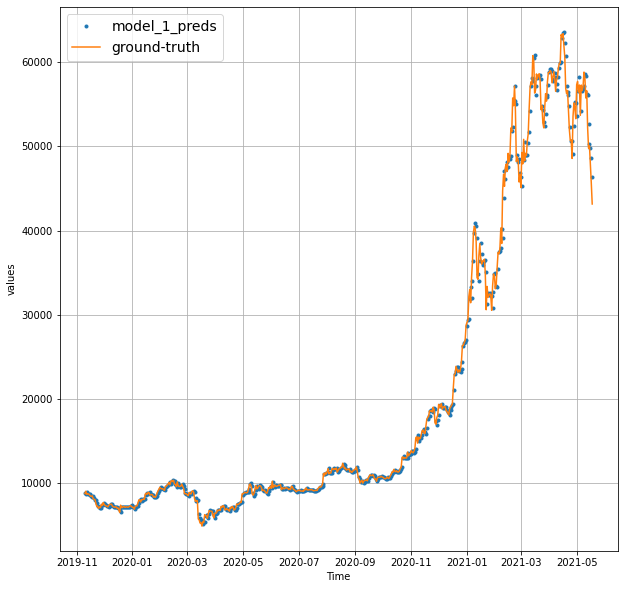

In [ ]:
# Plotting the predictions
plt.figure(figsize=(10,10))
plot_time_series(timesteps[-len(x_test):], model_1_preds, label="model_1_preds")
plot_time_series(timesteps[-len(model_1_preds):], y_test, label="ground-truth", format="-")


### Model 2: Dense (W=30, H=1)

In [ ]:
# Creating the windows and labels
WINDOWS_SIZE = 30
HORIZON = 1

windows, labels = make_windows(prices, window_size=WINDOWS_SIZE, horizon=HORIZON)

len(windows), len(labels)

(2757, 2757)

In [ ]:
# Splitting to testing and trainnig
x_train, x_test, y_train, y_test = make_time_train_test_split(windows, labels)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((2205, 30), (552, 30), (2205, 1), (552, 1))

In [ ]:
# Creating datasets
train_ds = preprocess_data(x_train, y_train)
test_ds = preprocess_data(x_test, y_test)

temp = []
temp.append(tf.squeeze(next(iter(tfds.as_numpy(train_ds.unbatch())))[1]).numpy())
temp

[196.025]

In [ ]:
# Build, compile, fit and evaluate the model
from tensorflow.keras import layers
model_2 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
], name="model_2_dense")

model_2.compile(loss="mae",
                optimizer="Adam",
                metrics=["mae", "mse"])

model_2.fit(x_train,
            y_train,
            batch_size=128,
            epochs=100,
            validation_data=(x_test, y_test),
            callbacks=[create_model_checkpoint(model_2.name)],
            )

# model_2, model_2_history, model_2_results = run_model_experiment(model_2, train_ds, test_ds, n_epochs=100, set_verbose=1)

Epoch 1/100
18/18 [==============================] - ETA: 0s - loss: 624.1816 - mae: 624.1816 - mse: 1592819.7500
Epoch 1: val_loss improved from inf to 1905.49768, saving model to models_experiment/model_2_dense
18/18 [==============================] - 2s 63ms/step - loss: 624.1816 - mae: 624.1816 - mse: 1592819.7500 - val_loss: 1905.4977 - val_mae: 1905.4977 - val_mse: 11108809.0000
Epoch 2/100
 1/18 [>.............................] - ETA: 0s - loss: 338.9364 - mae: 338.9364 - mse: 379397.6250
Epoch 2: val_loss improved from 1905.49768 to 1819.94763, saving model to models_experiment/model_2_dense
18/18 [==============================] - 1s 31ms/step - loss: 343.3178 - mae: 343.3178 - mse: 555572.3125 - val_loss: 1819.9476 - val_mae: 1819.9476 - val_mse: 9463942.0000
Epoch 3/100
 1/18 [>.............................] - ETA: 0s - loss: 246.7483 - mae: 246.7483 - mse: 271824.2188
Epoch 3: val_loss did not improve from 1819.94763
18/18 [==============================] - 0s 5ms/step - lo

In [ ]:
model_2 = tf.keras.models.load_model("/content/models_experiment/model_2_dense")

In [ ]:
model_2_preds = tf.squeeze(model_2.predict(x_test))
model_2_preds.shape

18/18 [==============================] - 0s 2ms/step


TensorShape([552])

In [ ]:
model_2_results = regression_evaluation(y_test, model_2_preds)

Multi dim input


In [ ]:
model_2_results

{'mae': 17228.71,
 'mse': 617975740.0,
 'rmse': 23800.34,
 'mape': 113.857864,
 'mase': 30.115953}

In [ ]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.5165248,
 'mase': 0.99957}

### Model 3: Dense (W=30, H=7)

In [ ]:
# Create data sets
HORIZON = 7
WINDOW_SIZE = 30

windows, labels = make_windows(prices, WINDOW_SIZE, HORIZON)

windows.shape, labels.shape, labels[0]

((2751, 30),
 (2751, 7),
 array([196.02499, 198.04883, 198.93233, 200.543  , 210.3075 , 225.02   ,
        248.25333]))

In [ ]:
# Split and turn into datasets
x_train, x_test, y_train, y_test = make_time_train_test_split(windows, labels)

train_ds = preprocess_data(x_train, y_train)
test_ds = preprocess_data(x_test, y_test)

train_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 30), dtype=tf.float32, name=None), TensorSpec(shape=(None, 7), dtype=tf.float32, name=None))>

In [ ]:
y_test.shape, y_train.shape

((551, 7), (2200, 7))

In [ ]:
# Create, compile, fit and evaluate the model
model_3 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON)
], name="model_3_dense")

model_3.compile(loss="mae",
                optimizer="Adam",
                metrics=["mae", "mse"])

model_3_history = model_3.fit(train_ds,
                              epochs=100,
                              validation_data=test_ds,
                              callbacks=[create_model_checkpoint(model_3.name)],
                              )

Epoch 1/100
11/18 [=================>............] - ETA: 0s - loss: 513.0674 - mae: 513.0674 - mse: 696649.6250  
Epoch 1: val_loss improved from inf to 3092.21826, saving model to models_experiment/model_3_dense
18/18 [==============================] - 3s 95ms/step - loss: 1147.1923 - mae: 1147.1923 - mse: 5192537.0000 - val_loss: 3092.2183 - val_mae: 3092.2183 - val_mse: 27651756.0000
Epoch 2/100
 1/18 [>.............................] - ETA: 0s - loss: 213.8195 - mae: 213.8195 - mse: 86432.6641
Epoch 2: val_loss did not improve from 3092.21826
18/18 [==============================] - 0s 4ms/step - loss: 1014.1324 - mae: 1014.1324 - mse: 5188647.0000 - val_loss: 3249.0818 - val_mae: 3249.0818 - val_mse: 30352584.0000
Epoch 3/100
 1/18 [>.............................] - ETA: 0s - loss: 229.5851 - mae: 229.5851 - mse: 93515.2188
Epoch 3: val_loss improved from 3092.21826 to 2916.10034, saving model to models_experiment/model_3_dense
18/18 [==============================] - 1s 29ms/step

In [ ]:
# Load the best model and evaluate the model

model_3 = tf.keras.models.load_model("models_experiment/model_3_dense")

model_3.evaluate(test_ds)

5/5 [==============================] - 0s 3ms/step - loss: 1470.1616 - mae: 1470.1616 - mse: 7009484.0000


[1470.16162109375, 1470.16162109375, 7009484.0]

In [ ]:
# Getting the predictions
model_3_preds = model_3.predict(test_ds)

model_3_preds.shape

5/5 [==============================] - 0s 3ms/step


(551, 7)

In [ ]:
# Regrresion evaluation

model_3_results = regression_evaluation(y_test, model_3_preds)

model_3_results

Multi dim input


{'mae': 1470.1616,
 'mse': 7009484.0,
 'rmse': 1682.0496,
 'mape': 6.490796,
 'mase': 2.6160698}

In [ ]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.5165248,
 'mase': 0.99957}

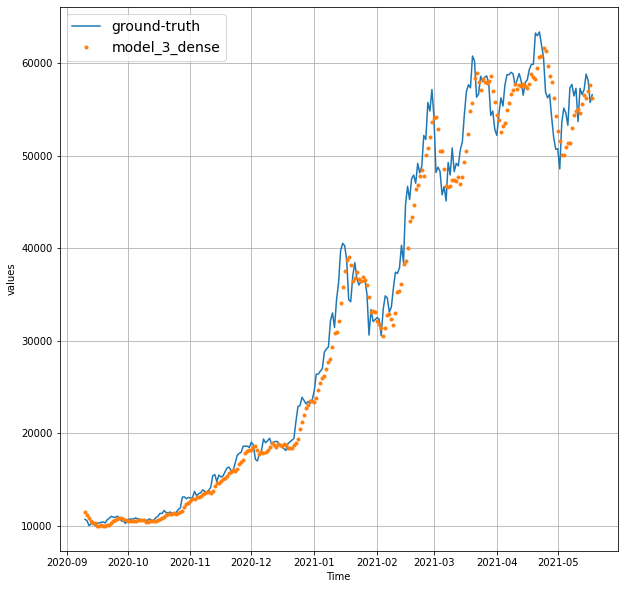

In [ ]:
# Plot the models predictions
offset=300
plt.figure(figsize=(10, 10))
plot_time_series(timesteps[-len(y_test):], y_test[:, 0], start=offset, label="ground-truth", format="-")
plot_time_series(timesteps[-len(y_test):], tf.reduce_mean(model_3_preds, axis=1), start=offset, label=model_3.name)

### Comparing all models so far

In [ ]:
# Turning all results into panda DF
all_model_res = pd.DataFrame({
    "naive": naive_results,
    "model_1": model_1_results,
    "model_2": model_2_results,
    "model_3": model_3_results
})

all_model_res.head()

,naive,model_1,model_2,model_3
mae,5.679802e+02,1.714234e+04,1.722871e+04,1.470162e+03
mse,1.147547e+06,6.146956e+08,6.179757e+08,7.009484e+06
rmse,1.071236e+03,2.371856e+04,2.380034e+04,1.682050e+03
mape,2.516525e+00,1.132741e+02,1.138579e+02,6.490796e+00
mase,9.995700e-01,3.011434e+01,3.011595e+01,2.616070e+00


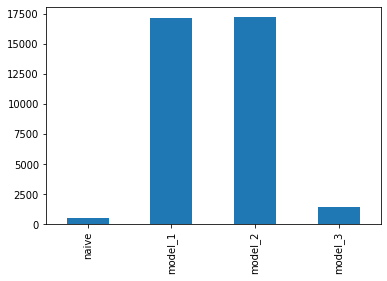

In [ ]:
all_model_res.T["mae"].plot(kind="bar")

### Model 4: Conv1D (W=7, H=1)

In [ ]:
# Creating the data
HORIZON = 1
WINDOW_SIZE = 7

windows, labels = make_windows(prices, WINDOW_SIZE, HORIZON)

windows.shape, labels.shape

((2780, 7), (2780, 1))

In [ ]:
# Split to test and train

x_train, x_test, y_train, y_test = make_time_train_test_split(windows, labels)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((2224, 7), (2224, 1), (556, 7), (556, 1))

In [ ]:
# Creating the Datasets

# train_ds = preprocess_data(x_train, y_train)
# test_ds = preprocess_data(x_test, y_test)

# train_ds

In [ ]:
# Create, Compile, Fit and Evaluate the model

model_4 = tf.keras.Sequential([
    layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
    layers.Conv1D(128, kernel_size=5, strides=1, padding="causal", activation="relu"),
    layers.Dense(HORIZON)
], name="model_4_Conv1D")

model_4.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.Adam())

model_4_history = model_4.fit(x_train,
                              y_train,
                              batch_size=128,
                              epochs=100,
                              validation_data=(x_test, y_test),
                              callbacks=[create_model_checkpoint(model_4.name)])

model_4 = tf.keras.models.load_model("/content/models_experiment/model_4_Conv1D")

# model_4, model_4_history, model_4_results = run_model_experiment(model_4, train_ds, test_ds, n_epochs=100, set_verbose=1)

Epoch 1/100


2023-01-31 13:15:42.073568: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8400
2023-01-31 13:15:43.554088: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


18/18 [==============================] - ETA: 0s - loss: 2097.5779  
Epoch 1: val_loss improved from inf to 5291.67383, saving model to models_experiment/model_4_Conv1D


INFO:tensorflow:Assets written to: models_experiment/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: models_experiment/model_4_Conv1D/assets


18/18 [==============================] - 5s 64ms/step - loss: 2097.5779 - val_loss: 5291.6738
Epoch 2/100
16/18 [=========================>....] - ETA: 0s - loss: 394.0418
Epoch 2: val_loss improved from 5291.67383 to 1319.96838, saving model to models_experiment/model_4_Conv1D


INFO:tensorflow:Assets written to: models_experiment/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: models_experiment/model_4_Conv1D/assets


18/18 [==============================] - 1s 47ms/step - loss: 387.3108 - val_loss: 1319.9684
Epoch 3/100
16/18 [=========================>....] - ETA: 0s - loss: 211.7994
Epoch 3: val_loss improved from 1319.96838 to 1051.22375, saving model to models_experiment/model_4_Conv1D


INFO:tensorflow:Assets written to: models_experiment/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: models_experiment/model_4_Conv1D/assets


18/18 [==============================] - 1s 43ms/step - loss: 208.5302 - val_loss: 1051.2238
Epoch 4/100
16/18 [=========================>....] - ETA: 0s - loss: 195.2542
Epoch 4: val_loss did not improve from 1051.22375
18/18 [==============================] - 0s 6ms/step - loss: 190.3202 - val_loss: 1060.1251
Epoch 5/100
17/18 [===========================>..] - ETA: 0s - loss: 183.4514
Epoch 5: val_loss improved from 1051.22375 to 1038.41211, saving model to models_experiment/model_4_Conv1D


INFO:tensorflow:Assets written to: models_experiment/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: models_experiment/model_4_Conv1D/assets


18/18 [==============================] - 1s 40ms/step - loss: 184.1285 - val_loss: 1038.4121
Epoch 6/100
 1/18 [>.............................] - ETA: 0s - loss: 170.1965
Epoch 6: val_loss improved from 1038.41211 to 1018.30420, saving model to models_experiment/model_4_Conv1D


INFO:tensorflow:Assets written to: models_experiment/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: models_experiment/model_4_Conv1D/assets


18/18 [==============================] - 1s 40ms/step - loss: 181.8794 - val_loss: 1018.3042
Epoch 7/100
 1/18 [>.............................] - ETA: 0s - loss: 154.6597
Epoch 7: val_loss improved from 1018.30420 to 1004.27362, saving model to models_experiment/model_4_Conv1D


INFO:tensorflow:Assets written to: models_experiment/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: models_experiment/model_4_Conv1D/assets


18/18 [==============================] - 1s 44ms/step - loss: 180.7150 - val_loss: 1004.2736
Epoch 8/100
17/18 [===========================>..] - ETA: 0s - loss: 178.5643
Epoch 8: val_loss improved from 1004.27362 to 993.51080, saving model to models_experiment/model_4_Conv1D


INFO:tensorflow:Assets written to: models_experiment/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: models_experiment/model_4_Conv1D/assets


18/18 [==============================] - 1s 51ms/step - loss: 177.6696 - val_loss: 993.5108
Epoch 9/100
18/18 [==============================] - ETA: 0s - loss: 175.4860
Epoch 9: val_loss did not improve from 993.51080
18/18 [==============================] - 0s 5ms/step - loss: 175.4860 - val_loss: 1010.4520
Epoch 10/100
 1/18 [>.............................] - ETA: 0s - loss: 146.9803
Epoch 10: val_loss did not improve from 993.51080
18/18 [==============================] - 0s 5ms/step - loss: 173.5130 - val_loss: 1014.7343
Epoch 11/100
 1/18 [>.............................] - ETA: 0s - loss: 171.9996
Epoch 11: val_loss improved from 993.51080 to 956.98065, saving model to models_experiment/model_4_Conv1D


INFO:tensorflow:Assets written to: models_experiment/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: models_experiment/model_4_Conv1D/assets


18/18 [==============================] - 1s 40ms/step - loss: 170.7428 - val_loss: 956.9807
Epoch 12/100
17/18 [===========================>..] - ETA: 0s - loss: 171.0524
Epoch 12: val_loss did not improve from 956.98065
18/18 [==============================] - 0s 5ms/step - loss: 171.0287 - val_loss: 970.5256
Epoch 13/100
18/18 [==============================] - ETA: 0s - loss: 166.9931
Epoch 13: val_loss improved from 956.98065 to 946.65796, saving model to models_experiment/model_4_Conv1D


INFO:tensorflow:Assets written to: models_experiment/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: models_experiment/model_4_Conv1D/assets


18/18 [==============================] - 1s 40ms/step - loss: 166.9931 - val_loss: 946.6580
Epoch 14/100
 1/18 [>.............................] - ETA: 0s - loss: 173.1176
Epoch 14: val_loss improved from 946.65796 to 944.14783, saving model to models_experiment/model_4_Conv1D


INFO:tensorflow:Assets written to: models_experiment/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: models_experiment/model_4_Conv1D/assets


18/18 [==============================] - 1s 39ms/step - loss: 164.8591 - val_loss: 944.1478
Epoch 15/100
 1/18 [>.............................] - ETA: 0s - loss: 103.9066
Epoch 15: val_loss improved from 944.14783 to 897.15009, saving model to models_experiment/model_4_Conv1D


INFO:tensorflow:Assets written to: models_experiment/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: models_experiment/model_4_Conv1D/assets


18/18 [==============================] - 1s 39ms/step - loss: 160.7454 - val_loss: 897.1501
Epoch 16/100
16/18 [=========================>....] - ETA: 0s - loss: 160.0246
Epoch 16: val_loss did not improve from 897.15009
18/18 [==============================] - 0s 6ms/step - loss: 160.6410 - val_loss: 940.3625
Epoch 17/100
16/18 [=========================>....] - ETA: 0s - loss: 156.9487
Epoch 17: val_loss improved from 897.15009 to 868.08649, saving model to models_experiment/model_4_Conv1D


INFO:tensorflow:Assets written to: models_experiment/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: models_experiment/model_4_Conv1D/assets


18/18 [==============================] - 1s 41ms/step - loss: 156.2436 - val_loss: 868.0865
Epoch 18/100
 1/18 [>.............................] - ETA: 0s - loss: 183.7018
Epoch 18: val_loss did not improve from 868.08649
18/18 [==============================] - 0s 5ms/step - loss: 153.7026 - val_loss: 870.7526
Epoch 19/100
 1/18 [>.............................] - ETA: 0s - loss: 171.0292
Epoch 19: val_loss improved from 868.08649 to 855.85016, saving model to models_experiment/model_4_Conv1D


INFO:tensorflow:Assets written to: models_experiment/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: models_experiment/model_4_Conv1D/assets


18/18 [==============================] - 1s 40ms/step - loss: 150.7256 - val_loss: 855.8502
Epoch 20/100
18/18 [==============================] - ETA: 0s - loss: 152.1707
Epoch 20: val_loss did not improve from 855.85016
18/18 [==============================] - 0s 5ms/step - loss: 152.1707 - val_loss: 892.0473
Epoch 21/100
17/18 [===========================>..] - ETA: 0s - loss: 147.6545
Epoch 21: val_loss improved from 855.85016 to 837.44861, saving model to models_experiment/model_4_Conv1D


INFO:tensorflow:Assets written to: models_experiment/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: models_experiment/model_4_Conv1D/assets


18/18 [==============================] - 1s 45ms/step - loss: 146.7176 - val_loss: 837.4486
Epoch 22/100
17/18 [===========================>..] - ETA: 0s - loss: 145.4735
Epoch 22: val_loss improved from 837.44861 to 801.10144, saving model to models_experiment/model_4_Conv1D


INFO:tensorflow:Assets written to: models_experiment/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: models_experiment/model_4_Conv1D/assets


18/18 [==============================] - 1s 42ms/step - loss: 145.7593 - val_loss: 801.1014
Epoch 23/100
 1/18 [>.............................] - ETA: 0s - loss: 123.0823
Epoch 23: val_loss improved from 801.10144 to 793.48157, saving model to models_experiment/model_4_Conv1D


INFO:tensorflow:Assets written to: models_experiment/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: models_experiment/model_4_Conv1D/assets


18/18 [==============================] - 1s 44ms/step - loss: 141.9630 - val_loss: 793.4816
Epoch 24/100
15/18 [========================>.....] - ETA: 0s - loss: 140.0366
Epoch 24: val_loss improved from 793.48157 to 783.41388, saving model to models_experiment/model_4_Conv1D


INFO:tensorflow:Assets written to: models_experiment/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: models_experiment/model_4_Conv1D/assets


18/18 [==============================] - 1s 46ms/step - loss: 139.4478 - val_loss: 783.4139
Epoch 25/100
16/18 [=========================>....] - ETA: 0s - loss: 140.5794
Epoch 25: val_loss did not improve from 783.41388
18/18 [==============================] - 0s 6ms/step - loss: 138.1488 - val_loss: 786.0203
Epoch 26/100
16/18 [=========================>....] - ETA: 0s - loss: 146.6613
Epoch 26: val_loss did not improve from 783.41388
18/18 [==============================] - 0s 6ms/step - loss: 142.7781 - val_loss: 1033.4811
Epoch 27/100
18/18 [==============================] - ETA: 0s - loss: 147.9971
Epoch 27: val_loss improved from 783.41388 to 745.29913, saving model to models_experiment/model_4_Conv1D


INFO:tensorflow:Assets written to: models_experiment/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: models_experiment/model_4_Conv1D/assets


18/18 [==============================] - 1s 40ms/step - loss: 147.9971 - val_loss: 745.2991
Epoch 28/100
 1/18 [>.............................] - ETA: 0s - loss: 141.7569
Epoch 28: val_loss improved from 745.29913 to 741.33014, saving model to models_experiment/model_4_Conv1D


INFO:tensorflow:Assets written to: models_experiment/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: models_experiment/model_4_Conv1D/assets


18/18 [==============================] - 1s 42ms/step - loss: 133.0608 - val_loss: 741.3301
Epoch 29/100
 1/18 [>.............................] - ETA: 0s - loss: 113.6268
Epoch 29: val_loss improved from 741.33014 to 727.38702, saving model to models_experiment/model_4_Conv1D


INFO:tensorflow:Assets written to: models_experiment/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: models_experiment/model_4_Conv1D/assets


18/18 [==============================] - 1s 54ms/step - loss: 130.7005 - val_loss: 727.3870
Epoch 30/100
18/18 [==============================] - ETA: 0s - loss: 130.7502
Epoch 30: val_loss improved from 727.38702 to 715.76813, saving model to models_experiment/model_4_Conv1D


INFO:tensorflow:Assets written to: models_experiment/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: models_experiment/model_4_Conv1D/assets


18/18 [==============================] - 1s 41ms/step - loss: 130.7502 - val_loss: 715.7681
Epoch 31/100
18/18 [==============================] - ETA: 0s - loss: 134.2215
Epoch 31: val_loss improved from 715.76813 to 707.66931, saving model to models_experiment/model_4_Conv1D


INFO:tensorflow:Assets written to: models_experiment/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: models_experiment/model_4_Conv1D/assets


18/18 [==============================] - 1s 41ms/step - loss: 134.2215 - val_loss: 707.6693
Epoch 32/100
 1/18 [>.............................] - ETA: 0s - loss: 124.8651
Epoch 32: val_loss did not improve from 707.66931
18/18 [==============================] - 0s 5ms/step - loss: 129.1258 - val_loss: 746.7557
Epoch 33/100
 1/18 [>.............................] - ETA: 0s - loss: 100.0676
Epoch 33: val_loss improved from 707.66931 to 706.61859, saving model to models_experiment/model_4_Conv1D


INFO:tensorflow:Assets written to: models_experiment/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: models_experiment/model_4_Conv1D/assets


18/18 [==============================] - 1s 40ms/step - loss: 126.7325 - val_loss: 706.6186
Epoch 34/100
 1/18 [>.............................] - ETA: 0s - loss: 132.1193
Epoch 34: val_loss did not improve from 706.61859
18/18 [==============================] - 0s 5ms/step - loss: 124.6743 - val_loss: 725.1351
Epoch 35/100
18/18 [==============================] - ETA: 0s - loss: 127.4341
Epoch 35: val_loss improved from 706.61859 to 684.94025, saving model to models_experiment/model_4_Conv1D


INFO:tensorflow:Assets written to: models_experiment/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: models_experiment/model_4_Conv1D/assets


18/18 [==============================] - 1s 37ms/step - loss: 127.4341 - val_loss: 684.9402
Epoch 36/100
 1/18 [>.............................] - ETA: 0s - loss: 126.0743
Epoch 36: val_loss improved from 684.94025 to 672.53326, saving model to models_experiment/model_4_Conv1D


INFO:tensorflow:Assets written to: models_experiment/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: models_experiment/model_4_Conv1D/assets


18/18 [==============================] - 1s 39ms/step - loss: 122.7113 - val_loss: 672.5333
Epoch 37/100
 1/18 [>.............................] - ETA: 0s - loss: 154.8951
Epoch 37: val_loss improved from 672.53326 to 666.48090, saving model to models_experiment/model_4_Conv1D


INFO:tensorflow:Assets written to: models_experiment/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: models_experiment/model_4_Conv1D/assets


18/18 [==============================] - 1s 40ms/step - loss: 121.2803 - val_loss: 666.4809
Epoch 38/100
 1/18 [>.............................] - ETA: 0s - loss: 116.2444
Epoch 38: val_loss improved from 666.48090 to 660.82111, saving model to models_experiment/model_4_Conv1D


INFO:tensorflow:Assets written to: models_experiment/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: models_experiment/model_4_Conv1D/assets


18/18 [==============================] - 1s 44ms/step - loss: 121.7859 - val_loss: 660.8211
Epoch 39/100
 1/18 [>.............................] - ETA: 0s - loss: 173.3800
Epoch 39: val_loss did not improve from 660.82111
18/18 [==============================] - 0s 5ms/step - loss: 122.8204 - val_loss: 697.3269
Epoch 40/100
 1/18 [>.............................] - ETA: 0s - loss: 152.3009
Epoch 40: val_loss did not improve from 660.82111
18/18 [==============================] - 0s 5ms/step - loss: 122.1179 - val_loss: 661.6505
Epoch 41/100
 1/18 [>.............................] - ETA: 0s - loss: 158.9391
Epoch 41: val_loss improved from 660.82111 to 646.80902, saving model to models_experiment/model_4_Conv1D


INFO:tensorflow:Assets written to: models_experiment/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: models_experiment/model_4_Conv1D/assets


18/18 [==============================] - 1s 38ms/step - loss: 118.7144 - val_loss: 646.8090
Epoch 42/100
 1/18 [>.............................] - ETA: 0s - loss: 123.6524
Epoch 42: val_loss improved from 646.80902 to 641.94775, saving model to models_experiment/model_4_Conv1D


INFO:tensorflow:Assets written to: models_experiment/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: models_experiment/model_4_Conv1D/assets


18/18 [==============================] - 1s 41ms/step - loss: 118.5372 - val_loss: 641.9478
Epoch 43/100
18/18 [==============================] - ETA: 0s - loss: 121.0624
Epoch 43: val_loss did not improve from 641.94775
18/18 [==============================] - 0s 5ms/step - loss: 121.0624 - val_loss: 644.8860
Epoch 44/100
17/18 [===========================>..] - ETA: 0s - loss: 117.7404
Epoch 44: val_loss did not improve from 641.94775
18/18 [==============================] - 0s 5ms/step - loss: 118.5707 - val_loss: 648.7808
Epoch 45/100
18/18 [==============================] - ETA: 0s - loss: 118.0089
Epoch 45: val_loss improved from 641.94775 to 631.99841, saving model to models_experiment/model_4_Conv1D


INFO:tensorflow:Assets written to: models_experiment/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: models_experiment/model_4_Conv1D/assets


18/18 [==============================] - 1s 39ms/step - loss: 118.0089 - val_loss: 631.9984
Epoch 46/100
 1/18 [>.............................] - ETA: 0s - loss: 97.7067
Epoch 46: val_loss improved from 631.99841 to 631.35632, saving model to models_experiment/model_4_Conv1D


INFO:tensorflow:Assets written to: models_experiment/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: models_experiment/model_4_Conv1D/assets


18/18 [==============================] - 1s 40ms/step - loss: 116.3052 - val_loss: 631.3563
Epoch 47/100
 1/18 [>.............................] - ETA: 0s - loss: 135.7987
Epoch 47: val_loss improved from 631.35632 to 624.35236, saving model to models_experiment/model_4_Conv1D


INFO:tensorflow:Assets written to: models_experiment/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: models_experiment/model_4_Conv1D/assets


18/18 [==============================] - 1s 39ms/step - loss: 116.6362 - val_loss: 624.3524
Epoch 48/100
18/18 [==============================] - ETA: 0s - loss: 115.0021
Epoch 48: val_loss improved from 624.35236 to 622.21997, saving model to models_experiment/model_4_Conv1D


INFO:tensorflow:Assets written to: models_experiment/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: models_experiment/model_4_Conv1D/assets


18/18 [==============================] - 1s 54ms/step - loss: 115.0021 - val_loss: 622.2200
Epoch 49/100
 1/18 [>.............................] - ETA: 0s - loss: 86.7312
Epoch 49: val_loss did not improve from 622.21997
18/18 [==============================] - 0s 5ms/step - loss: 115.2439 - val_loss: 657.7130
Epoch 50/100
18/18 [==============================] - ETA: 0s - loss: 114.8018
Epoch 50: val_loss did not improve from 622.21997
18/18 [==============================] - 0s 5ms/step - loss: 114.8018 - val_loss: 641.2914
Epoch 51/100
 1/18 [>.............................] - ETA: 0s - loss: 95.4861
Epoch 51: val_loss did not improve from 622.21997
18/18 [==============================] - 0s 5ms/step - loss: 117.6168 - val_loss: 695.7469
Epoch 52/100
 1/18 [>.............................] - ETA: 0s - loss: 169.5840
Epoch 52: val_loss did not improve from 622.21997
18/18 [==============================] - 0s 5ms/step - loss: 117.5175 - val_loss: 686.5941
Epoch 53/100
 1/18 [>.........

INFO:tensorflow:Assets written to: models_experiment/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: models_experiment/model_4_Conv1D/assets


18/18 [==============================] - 1s 40ms/step - loss: 118.9335 - val_loss: 614.5728
Epoch 54/100
18/18 [==============================] - ETA: 0s - loss: 115.4025
Epoch 54: val_loss did not improve from 614.57275
18/18 [==============================] - 0s 5ms/step - loss: 115.4025 - val_loss: 619.7332
Epoch 55/100
 1/18 [>.............................] - ETA: 0s - loss: 93.7438
Epoch 55: val_loss improved from 614.57275 to 611.94574, saving model to models_experiment/model_4_Conv1D


INFO:tensorflow:Assets written to: models_experiment/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: models_experiment/model_4_Conv1D/assets


18/18 [==============================] - 1s 40ms/step - loss: 114.0426 - val_loss: 611.9457
Epoch 56/100
 1/18 [>.............................] - ETA: 0s - loss: 106.0585
Epoch 56: val_loss did not improve from 611.94574
18/18 [==============================] - 0s 5ms/step - loss: 112.2343 - val_loss: 635.4819
Epoch 57/100
 1/18 [>.............................] - ETA: 0s - loss: 99.0113
Epoch 57: val_loss did not improve from 611.94574
18/18 [==============================] - 0s 5ms/step - loss: 119.2806 - val_loss: 686.1995
Epoch 58/100
 1/18 [>.............................] - ETA: 0s - loss: 117.9384
Epoch 58: val_loss did not improve from 611.94574
18/18 [==============================] - 0s 5ms/step - loss: 113.7627 - val_loss: 620.5838
Epoch 59/100
 1/18 [>.............................] - ETA: 0s - loss: 95.2824
Epoch 59: val_loss did not improve from 611.94574
18/18 [==============================] - 0s 5ms/step - loss: 115.0276 - val_loss: 612.9280
Epoch 60/100
 1/18 [>.........

INFO:tensorflow:Assets written to: models_experiment/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: models_experiment/model_4_Conv1D/assets


18/18 [==============================] - 1s 39ms/step - loss: 112.5586 - val_loss: 599.8739
Epoch 62/100
 1/18 [>.............................] - ETA: 0s - loss: 84.4510
Epoch 62: val_loss did not improve from 599.87390
18/18 [==============================] - 0s 4ms/step - loss: 112.9642 - val_loss: 667.6081
Epoch 63/100
17/18 [===========================>..] - ETA: 0s - loss: 115.6166
Epoch 63: val_loss did not improve from 599.87390
18/18 [==============================] - 0s 6ms/step - loss: 115.8921 - val_loss: 741.6867
Epoch 64/100
17/18 [===========================>..] - ETA: 0s - loss: 119.9757
Epoch 64: val_loss did not improve from 599.87390
18/18 [==============================] - 0s 5ms/step - loss: 118.4116 - val_loss: 600.7828
Epoch 65/100
18/18 [==============================] - ETA: 0s - loss: 111.5529
Epoch 65: val_loss did not improve from 599.87390
18/18 [==============================] - 0s 5ms/step - loss: 111.5529 - val_loss: 604.0500
Epoch 66/100
 1/18 [>........

INFO:tensorflow:Assets written to: models_experiment/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: models_experiment/model_4_Conv1D/assets


18/18 [==============================] - 0s 28ms/step - loss: 111.4630 - val_loss: 594.7301
Epoch 67/100
 1/18 [>.............................] - ETA: 0s - loss: 101.3996
Epoch 67: val_loss improved from 594.73010 to 589.10913, saving model to models_experiment/model_4_Conv1D


INFO:tensorflow:Assets written to: models_experiment/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: models_experiment/model_4_Conv1D/assets


18/18 [==============================] - 1s 37ms/step - loss: 112.8517 - val_loss: 589.1091
Epoch 68/100
 1/18 [>.............................] - ETA: 0s - loss: 106.1046
Epoch 68: val_loss did not improve from 589.10913
18/18 [==============================] - 0s 5ms/step - loss: 111.4189 - val_loss: 589.8317
Epoch 69/100
 1/18 [>.............................] - ETA: 0s - loss: 118.1843
Epoch 69: val_loss did not improve from 589.10913
18/18 [==============================] - 0s 5ms/step - loss: 110.6448 - val_loss: 609.6241
Epoch 70/100
 1/18 [>.............................] - ETA: 0s - loss: 127.3081
Epoch 70: val_loss did not improve from 589.10913
18/18 [==============================] - 0s 5ms/step - loss: 113.1726 - val_loss: 614.9932
Epoch 71/100
 1/18 [>.............................] - ETA: 0s - loss: 141.6060
Epoch 71: val_loss did not improve from 589.10913
18/18 [==============================] - 0s 4ms/step - loss: 110.4134 - val_loss: 635.5714
Epoch 72/100
 1/18 [>.......

INFO:tensorflow:Assets written to: models_experiment/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: models_experiment/model_4_Conv1D/assets


18/18 [==============================] - 0s 27ms/step - loss: 109.3909 - val_loss: 585.5657
Epoch 73/100
 1/18 [>.............................] - ETA: 0s - loss: 95.7672
Epoch 73: val_loss did not improve from 585.56567
18/18 [==============================] - 0s 4ms/step - loss: 109.9402 - val_loss: 586.8409
Epoch 74/100
 1/18 [>.............................] - ETA: 0s - loss: 114.2984
Epoch 74: val_loss did not improve from 585.56567
18/18 [==============================] - 0s 4ms/step - loss: 109.8165 - val_loss: 588.4190
Epoch 75/100
 1/18 [>.............................] - ETA: 0s - loss: 112.0063
Epoch 75: val_loss did not improve from 585.56567
18/18 [==============================] - 0s 4ms/step - loss: 110.1229 - val_loss: 593.4402
Epoch 76/100
 1/18 [>.............................] - ETA: 0s - loss: 166.9523
Epoch 76: val_loss did not improve from 585.56567
18/18 [==============================] - 0s 5ms/step - loss: 108.5864 - val_loss: 616.3694
Epoch 77/100
 1/18 [>........

INFO:tensorflow:Assets written to: models_experiment/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: models_experiment/model_4_Conv1D/assets


18/18 [==============================] - 1s 40ms/step - loss: 109.6845 - val_loss: 582.8027
Epoch 79/100
 1/18 [>.............................] - ETA: 0s - loss: 127.5169
Epoch 79: val_loss improved from 582.80273 to 581.69592, saving model to models_experiment/model_4_Conv1D


INFO:tensorflow:Assets written to: models_experiment/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: models_experiment/model_4_Conv1D/assets


18/18 [==============================] - 1s 40ms/step - loss: 107.9298 - val_loss: 581.6959
Epoch 80/100
18/18 [==============================] - ETA: 0s - loss: 108.4151
Epoch 80: val_loss did not improve from 581.69592
18/18 [==============================] - 0s 5ms/step - loss: 108.4151 - val_loss: 597.1688
Epoch 81/100
18/18 [==============================] - ETA: 0s - loss: 108.4820
Epoch 81: val_loss did not improve from 581.69592
18/18 [==============================] - 0s 5ms/step - loss: 108.4820 - val_loss: 610.8722
Epoch 82/100
 1/18 [>.............................] - ETA: 0s - loss: 108.8604
Epoch 82: val_loss did not improve from 581.69592
18/18 [==============================] - 0s 4ms/step - loss: 111.0765 - val_loss: 592.8994
Epoch 83/100
 1/18 [>.............................] - ETA: 0s - loss: 132.5730
Epoch 83: val_loss did not improve from 581.69592
18/18 [==============================] - 0s 4ms/step - loss: 111.3818 - val_loss: 618.2853
Epoch 84/100
 1/18 [>.......

INFO:tensorflow:Assets written to: models_experiment/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: models_experiment/model_4_Conv1D/assets


18/18 [==============================] - 0s 28ms/step - loss: 111.9614 - val_loss: 579.4935
Epoch 86/100
 1/18 [>.............................] - ETA: 0s - loss: 52.0208
Epoch 86: val_loss did not improve from 579.49347
18/18 [==============================] - 0s 4ms/step - loss: 107.9816 - val_loss: 597.5715
Epoch 87/100
 1/18 [>.............................] - ETA: 0s - loss: 123.5256
Epoch 87: val_loss did not improve from 579.49347
18/18 [==============================] - 0s 5ms/step - loss: 109.2259 - val_loss: 607.2458
Epoch 88/100
18/18 [==============================] - ETA: 0s - loss: 107.1729
Epoch 88: val_loss did not improve from 579.49347
18/18 [==============================] - 0s 5ms/step - loss: 107.1729 - val_loss: 583.1082
Epoch 89/100
 1/18 [>.............................] - ETA: 0s - loss: 113.7361
Epoch 89: val_loss improved from 579.49347 to 575.77948, saving model to models_experiment/model_4_Conv1D


INFO:tensorflow:Assets written to: models_experiment/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: models_experiment/model_4_Conv1D/assets


18/18 [==============================] - 0s 25ms/step - loss: 108.6239 - val_loss: 575.7795
Epoch 90/100
 1/18 [>.............................] - ETA: 0s - loss: 75.6632
Epoch 90: val_loss did not improve from 575.77948
18/18 [==============================] - 0s 4ms/step - loss: 107.4291 - val_loss: 627.1108
Epoch 91/100
 1/18 [>.............................] - ETA: 0s - loss: 106.6921
Epoch 91: val_loss improved from 575.77948 to 574.90649, saving model to models_experiment/model_4_Conv1D


INFO:tensorflow:Assets written to: models_experiment/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: models_experiment/model_4_Conv1D/assets


18/18 [==============================] - 1s 41ms/step - loss: 114.2810 - val_loss: 574.9065
Epoch 92/100
 1/18 [>.............................] - ETA: 0s - loss: 108.2595
Epoch 92: val_loss did not improve from 574.90649
18/18 [==============================] - 0s 4ms/step - loss: 107.7197 - val_loss: 593.2796
Epoch 93/100
 1/18 [>.............................] - ETA: 0s - loss: 132.6171
Epoch 93: val_loss did not improve from 574.90649
18/18 [==============================] - 0s 4ms/step - loss: 111.7601 - val_loss: 589.0468
Epoch 94/100
 1/18 [>.............................] - ETA: 0s - loss: 105.5110
Epoch 94: val_loss did not improve from 574.90649
18/18 [==============================] - 0s 4ms/step - loss: 107.2201 - val_loss: 623.6689
Epoch 95/100
 1/18 [>.............................] - ETA: 0s - loss: 105.3825
Epoch 95: val_loss did not improve from 574.90649
18/18 [==============================] - 0s 4ms/step - loss: 116.6669 - val_loss: 600.0515
Epoch 96/100
18/18 [========

OSError: ignored

In [ ]:
model_4.summary()

In [ ]:
model_4.evaluate(x_test, y_test)

In [ ]:
model_4_preds = tf.squeeze(model_4.predict(x_test))

model_4_preds.shape, model_4_preds[:5]

In [ ]:
model_4_results = regression_evaluation(tf.squeeze(y_test), model_4_preds)

model_4_results

### Model 5: LSTM (W=7,H=1)

In [ ]:
# Build the Model(the data is same as before)

from tensorflow.keras import layers

inputs = layers.Input(shape=WINDOW_SIZE)

x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
x = layers.LSTM(128, activation="relu")(x)

output = layers.Dense(HORIZON)(x)

model_5 = tf.keras.Model(inputs, output, name="model_5_LSTM")

model_5.compile(loss="mae",
                optimizer="Adam")

model_5_history = model_5.fit(x_train,
                              y_train,
                              epochs=100,
                              batch_size=128,
                              validation_data=(x_test, y_test),
                              callbacks=[create_model_checkpoint(model_5.name)])

model_5 = tf.keras.models.load_model("/content/models_experiment/model_5_LSTM")


Epoch 1/100
10/18 [===============>..............] - ETA: 0s - loss: 2706.8340 
Epoch 1: val_loss improved from inf to 8065.33643, saving model to models_experiment/model_5_LSTM
18/18 [==============================] - 3s 129ms/step - loss: 2382.5754 - val_loss: 8065.3364
Epoch 2/100
10/18 [===============>..............] - ETA: 0s - loss: 533.3405 
Epoch 2: val_loss improved from 8065.33643 to 1242.04065, saving model to models_experiment/model_5_LSTM
18/18 [==============================] - 2s 117ms/step - loss: 435.8410 - val_loss: 1242.0406
Epoch 3/100
11/18 [=================>............] - ETA: 0s - loss: 182.3826
Epoch 3: val_loss improved from 1242.04065 to 1016.05438, saving model to models_experiment/model_5_LSTM
18/18 [==============================] - 2s 140ms/step - loss: 189.2068 - val_loss: 1016.0544
Epoch 4/100
11/18 [=================>............] - ETA: 0s - loss: 189.1058
Epoch 4: val_loss improved from 1016.05438 to 1007.63196, saving model to models_experiment/mo

In [ ]:
model_5_preds = tf.squeeze(model_5.predict(x_test))

model_5_preds[:5]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(5,), dtype=float32, numpy=array([8916.388, 8830.272, 9029.714, 8803.884, 8774.253], dtype=float32)>

In [ ]:
model_5_results = regression_evaluation(tf.squeeze(y_test), model_5_preds)

model_5_results

{'mae': 572.0936,
 'mse': 1190181.6,
 'rmse': 1090.9545,
 'mape': 2.573253,
 'mase': 1.00501}

In [ ]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.5165248,
 'mase': 0.99957}

### Creating a multiveriate data

In [ ]:
# adding the bitcoin halving events to our dataset
block_reward_1 = 50 # 3 January 2009 - this block reward isn't in our dataset (our data starts from 01 October 2013)
block_reward_2 = 25 # 8 November 2012
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 18 May 2020

# Block reward dates
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-18")

In [ ]:
# Getting the days diff
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

(1012, 2421)

In [ ]:
# Adding the block_reward column
prices_block = bitcoin_prices.copy()
prices_block["block_reward"] = 0
prices_block.head()

,Price,block_reward
Date,,
2013-10-01,123.65499,0
2013-10-02,125.45500,0
2013-10-03,108.58483,0
2013-10-04,118.67466,0
2013-10-05,121.33866,0


In [ ]:
# Adding the block reward values
prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
prices_block.iloc[block_reward_2_days::block_reward_3_days, -1] = block_reward_3
prices_block.iloc[block_reward_3_days:, -1] = block_reward_4

In [ ]:
prices_block.head()

,Price,block_reward
Date,,
2013-10-01,123.65499,25.0
2013-10-02,125.45500,25.0
2013-10-03,108.58483,25.0
2013-10-04,118.67466,25.0
2013-10-05,121.33866,25.0


In [ ]:
prices_block.tail()

,Price,block_reward
Date,,
2021-05-14,49764.132082,6.25
2021-05-15,50032.693137,6.25
2021-05-16,47885.625255,6.25
2021-05-17,45604.615754,6.25
2021-05-18,43144.471291,6.25


In [ ]:
# Setting params for the data
Horizon = 1
WINDOWS_SIZE = 7

In [ ]:
# Copy the df
prices_block_windowed = prices_block.copy()

In [ ]:
from pandas._libs.tslibs import period
# Add windowed data to the df
for i in range(WINDOWS_SIZE):
  prices_block_windowed[f"Price+{i+1}"] = prices_block_windowed["Price"].shift(periods=i+1)

In [ ]:
prices_block_windowed.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25.0,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25.0,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25.0,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25.0,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25.0,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25.0,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25.0,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25.0,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


In [ ]:
# Split the data to windows and horizons
X = prices_block_windowed.dropna().drop("Price", axis=1).astype(np.float32)
Y = prices_block_windowed.dropna()["Price"].astype(np.float32)

X.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [ ]:
Y.head()

Date
2013-10-08    123.032997
2013-10-09    124.049004
2013-10-10    125.961159
2013-10-11    125.279663
2013-10-12    125.927498
Name: Price, dtype: float32

In [ ]:
# split to train and test

x_train, x_test, y_train, y_test = make_time_train_test_split(X, Y)

len(x_train), len(x_test),len(y_train), len(y_test)

(2224, 556, 2224, 556)

### Model 6: same as 1 with multivariate

In [ ]:
# Create and compile

from tensorflow.keras import layers

model_6 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(Horizon)
], name="model_6_multi")

model_6.compile(loss="mae",
                optimizer="Adam")

NameError: ignored

In [ ]:
# fit

model_6_history = model_6.fit(x_train,
                              y_train,
                              epochs=100,
                              batch_size=128,
                              validation_data=(x_test, y_test),
                              callbacks=[create_model_checkpoint(model_6.name)])

In [ ]:
# Load best model

model_6 =tf.keras.models.load_model("/content/models_experiment/model_6_multi")

In [ ]:
model_6.summary()

In [ ]:
# Making predictions and evaluating

model_6_preds = tf.squeeze(model_6.predict(x_test))

model_6_preds.shape

NameError: ignored

In [ ]:
# Getting model results

model_6_results = regression_evaluation(y_test, model_6_preds)

model_6_results

In [ ]:
naive_results

### Model 7: N-BEATS

replicating the n-beats model
https://arxiv.org/abs/1905.10437

In [ ]:
# Creating the block layer
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self,
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs):
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

  # A block containts stack of 4 fully connected layers with relu activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]

    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs):
    x = inputs
    for layer in self.hidden:
      x = layer(x)
    theta = self.theta_layer(x)
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast



In [ ]:
# Testing the NBeats class layer
NBeats_block_layer = NBeatsBlock(input_size=WINDOWS_SIZE,
                                 theta_size=WINDOWS_SIZE+HORIZON,
                                 horizon=HORIZON,
                                 n_neurons=128,
                                 n_layers=4)

NameError: ignored

In [ ]:
# Create test inputs 
test_inputs = tf.expand_dims(tf.range(WINDOWS_SIZE) + 1, axis=0)
test_inputs

In [ ]:
# Passing the test inputs to the block layer
backcast, forecast = NBeats_block_layer(test_inputs)

backcast, forecast

In [ ]:
# Preparing the data for the NBeats model
HORIZON = 1
WINDOWS_SIZE = 7

In [ ]:
bitcoin_prices.head()

In [ ]:
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOWS_SIZE):
  bitcoin_prices_nbeats[f"Price+{i+1}"] = bitcoin_prices_nbeats["Price"].shift(periods=i+1)

bitcoin_prices_nbeats.head()

NameError: ignored

In [ ]:
X = bitcoin_prices_nbeats.dropna().drop("Price", axis=1)
Y = bitcoin_prices_nbeats.dropna()["Price"]

# Split to train and test

x_train, x_test, y_train, y_test = make_time_train_test_split(X, Y)

x_train.shape, y_train.shape

In [ ]:
# Creating data pipelines
BATCH_SIZE=1024

train_ds = preprocess_data(x_train, y_train, batch_size=BATCH_SIZE)
test_ds = preprocess_data(x_test, y_test, batch_size=BATCH_SIZE)

train_ds, test_ds

In [ ]:
# Setting hyperparameters for the N-Beats model
N_EPOCHS = 5000
N_NEURONS = 512
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOWS_SIZE * HORIZON
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

In [ ]:
# 
%%time

tf.random.set_seed(42)

# 1. Setting NBeats Layer
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                  theta_size=THETA_SIZE,
                                  horizon=HORIZON,
                                  n_neurons=N_NEURONS,
                                  n_layers=N_LAYERS,
                                  name="initial_block")

# 2. Create input layer
stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")

# 3. Creating initial backcast and forecast
residuals, forecast = nbeats_block_layer(stack_input)

# 4. Creating stacks of blocks layers
for i, _ in enumerate(range(N_STACKS-1)):
  backcast, block_forecast = NBeatsBlock(input_size=INPUT_SIZE,
                                  theta_size=THETA_SIZE,
                                  horizon=HORIZON,
                                  n_neurons=N_NEURONS,
                                  n_layers=N_LAYERS,
                                  name=f"NBeatsBlock_{i}")(residuals)
  # 6. Creating the residual stacking                                 
  residuals = layers.subtract([residuals, backcast], name=f"substract_{i}")
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Creating the model
model_7 = tf.keras.Model(stack_input, forecast, name="model_7_nbeats")

# 8. Compile
model_7.compile(loss="mae",
                optimizer="Adam")

# 9. Fitting
model_7_history = model_7.fit(train_ds,
                              epochs=N_EPOCHS,
                              validation_data=test_ds,
                              verbose=0,
                              callbacks=[
                                  tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                                   patience=200,
                                                                   restore_best_weights=True),
                                  tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                                       patience=100,
                                                                       verbose=1)       
                              ])
  

In [ ]:
# Getting predictions from the model
model_7_preds = tf.squeeze(model_7.predict(test_ds))

model_7_preds[:5]

In [ ]:
# Evaluating the model
model_7_results = regression_evaluation(y_test, model_7_preds)

model_7_results

NameError: ignored

In [ ]:
model_1_results

In [ ]:
# Plotting the model
from tensorflow.keras.utils import plot_model

plot_model(model_7)

### Model 8: Creating stacked models on top of each other

In [ ]:
# Hyperparameters 
HORIZON, WINDOWS_SIZE = 1, 7

In [ ]:
def get_ensamble_models(horizon=HORIZON,
                        num_epochs=1000,
                        test_ds=test_ds,
                        train_ds=train_ds,
                        num_iter=5,
                        loss_fns=["mse", "mae", "mape"]
                        ):
  """
  Returns a list of num_iter models each trained on loss_fns losses.
  """ 
  ensamble_models = []

  for i in range(num_iter):
    for loss_func in loss_fns:
      print(f"Optimizing model by reducing: {loss_func} for {num_epochs} epochs, model number {i}")

      model = tf.keras.Sequential([
          layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
          layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
          layers.Dense(horizon)
      ])

      model.compile(loss=loss_func,
                    optimizer="Adam",
                    metrics=["mae", "mse"])
      
      # Fit the model
      model.fit(train_ds,
                epochs=num_epochs,
                verbose=0,
                validation_data=test_ds,
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                            patience=200,
                                                            restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                                patience=100,
                                                                verbose=1)])
      ensamble_models.append(model)
    
  return ensamble_models

In [ ]:
ensamble_models = get_ensamble_models()

Optimizing model by reducing: mse for 1000 epochs, model number 0

Epoch 909: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing model by reducing: mae for 1000 epochs, model number 0

Epoch 627: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 795: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 895: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Optimizing model by reducing: mape for 1000 epochs, model number 0

Epoch 248: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 594: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 694: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Optimizing model by reducing: mse for 1000 epochs, model number 1

Epoch 386: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 486: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing mode

In [ ]:
ensamble_models

In [ ]:
# Creating a function to get predictions from the ensamble
def get_ensamble_preds(ensamble_models, test_ds=test_ds):
  ensamble_preds = []
  for model in ensamble_models:
    preds = tf.squeeze(model.predict(test_ds, verbose=0))
    ensamble_preds.append(preds)
  return tf.constant(tf.squeeze(ensamble_preds))

In [ ]:
# get the predictions
ensamble_preds = get_ensamble_preds(ensamble_models=ensamble_models)

In [ ]:
# Reducing the predictions using mean and median
ensamble_mean = tf.reduce_mean(ensamble_preds, axis=0)
ensamble_median = np.median(ensamble_preds, axis=0)

In [ ]:
ensamble_results = regression_evaluation(y_test, ensamble_mean)
ensamble_results

{'mae': 567.3724,
 'mse': 1145301.5,
 'rmse': 1070.1876,
 'mape': 2.5761926,
 'mase': 0.99671614}

In [ ]:
ensamble_results = regression_evaluation(y_test, ensamble_median)
ensamble_results

{'mae': 565.7047,
 'mse': 1144894.9,
 'rmse': 1069.9976,
 'mape': 2.5637705,
 'mase': 0.9937865}

In [ ]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.5165248,
 'mase': 0.99957}

In [ ]:
# Turning the prediction to a 95% confidance range
def get_upper_lower(preds):

  # get the standard deveation
  std = tf.math.reduce_std(preds, axis=0)

  # getting the intereval in which 95 of the data lays
  interval = 1.96 * std

  # getting the lower and upper
  preds_mean = tf.reduce_mean(preds, axis=0)
  lower, upper = preds_mean - interval, preds_mean + interval

  return lower, upper

In [ ]:
# getting the range
lower, upper = get_upper_lower(ensamble_preds)

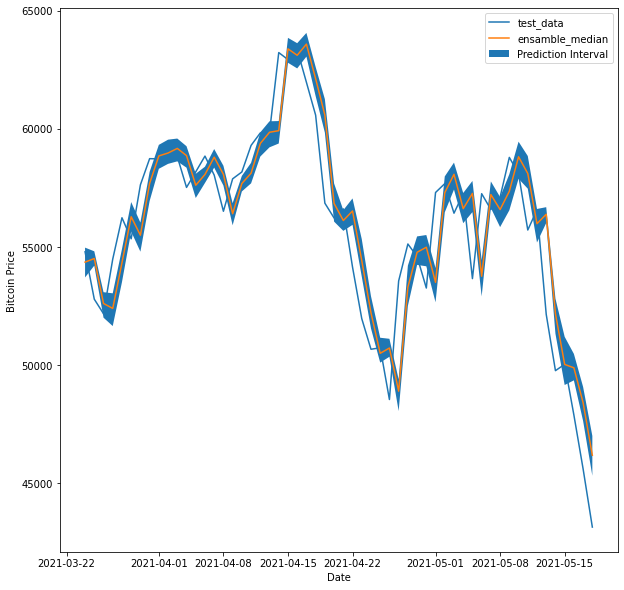

In [ ]:
# Plot the range
offset=500
plt.figure(figsize=(10,10))
plt.plot(x_test.index[offset:], y_test[offset:], "-", label="test_data")
plt.plot(x_test.index[offset:], ensamble_median[offset:], "-", label="ensamble_median")
plt.xlabel("Date")
plt.ylabel("Bitcoin Price")
plt.fill_between(x_test.index[offset:],
                 lower[offset:],
                 upper[offset:],
                 label="Prediction Interval")


plt.legend()

### Model 9: Predicting into the Future

Training on the full history to predict the future

In [ ]:
prices_block_windowed.tail()

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2021-05-14,49764.132082,6.25,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679,57107.120672,56583.849879
2021-05-15,50032.693137,6.25,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679,57107.120672
2021-05-16,47885.625255,6.25,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679
2021-05-17,45604.615754,6.25,47885.625255,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426
2021-05-18,43144.471291,6.25,45604.615754,47885.625255,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651


In [ ]:
# Getting all the data
x_all = prices_block_windowed.dropna().drop(["Price", "block_reward"], axis=1).to_numpy()
y_all = prices_block_windowed.dropna()["Price"].to_numpy()

In [ ]:
# Create DS from the data
all_ds = preprocess_data(x_all, y_all, batch_size=1024)

all_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [ ]:
# Creating and compiling the model

model_9 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
], name="model_9_future")

model_9.compile(loss="mae",
                optimizer="Adam")

model_9_history = model_9.fit(all_ds,
                              epochs=100,
                              verbose=0,
                              callbacks=[tf.keras.callbacks.ModelCheckpoint(monitor="loss",
                                                                            filepath=f"/content/models_experiment/{model_9.name}",
                                                                            verbose=0,
                                                                            save_best_only=True)])

In [ ]:
# Predicting in to the future
INTO_FUTURE = 100

In [ ]:
# a Function that predicts into the future
def future_predict(data, model, window_size, into_future):
  future = []
  last_window = data[-window_size:]
  for _ in range(into_future):
    pred = model.predict(tf.expand_dims(data[-window_size:], axis=0), verbose=0)
    future.append(pred)
    data = np.concatenate((data, [tf.squeeze(pred)]))
  return future

In [ ]:
future_forcast = future_predict(y_all, model_9, 7, INTO_FUTURE)
tf.squeeze(future_forcast)

1/1 [==============================] - 0s 18ms/step


<tf.Tensor: shape=(100,), dtype=float32, numpy=
array([55599.617, 52404.23 , 49858.535, 48777.906, 46094.42 , 46048.7  ,
       49036.457, 55227.2  , 51948.527, 48970.26 , 47164.812, 46085.895,
       48465.75 , 52554.145, 54548.65 , 50715.652, 47621.324, 46513.316,
       47667.863, 51345.633, 54237.336, 53178.133, 49048.387, 46686.906,
       47288.91 , 50179.023, 53659.355, 54287.066, 51246.355, 47566.383,
       46870.29 , 49210.945, 52778.87 , 54750.53 , 53046.94 , 49255.836,
       46947.35 , 48275.656, 51757.984, 54644.586, 54405.395, 51126.434,
       47832.19 , 47623.94 , 50568.125, 54105.855, 55245.72 , 52932.707,
       49255.797, 47557.35 , 49430.617, 53155.21 , 55538.707, 54489.516,
       50990.74 , 48145.47 , 48629.047, 51943.492, 55257.355, 55648.72 ,
       52804.605, 49311.07 , 48316.72 , 50723.07 , 54467.605, 56266.562,
       54518.273, 50885.195, 48584.414, 49765.105, 53338.59 , 56266.02 ,
       55923.086, 52680.125, 49467.918, 49207.82 , 52106.676, 55703.586,
   

In [ ]:
def get_future_dates(start_date, into_future, offset=1):
  start_date = start_date + np.timedelta64(offset, "D")
  end_date = start_date + np.timedelta64(into_future, "D")
  return np.arange(start_date, end_date, dtype="datetime64[D]")
     

# Last timestep of timesteps
last_timestep = bitcoin_prices.index[-1]
last_timestep

Timestamp('2021-05-18 00:00:00')

In [ ]:
# Get next two week of timesteps
next_time_steps = get_future_dates(start_date=last_timestep,
                                   into_future=INTO_FUTURE)
next_time_steps

array(['2021-05-19', '2021-05-20', '2021-05-21', '2021-05-22',
       '2021-05-23', '2021-05-24', '2021-05-25', '2021-05-26',
       '2021-05-27', '2021-05-28', '2021-05-29', '2021-05-30',
       '2021-05-31', '2021-06-01', '2021-06-02', '2021-06-03',
       '2021-06-04', '2021-06-05', '2021-06-06', '2021-06-07',
       '2021-06-08', '2021-06-09', '2021-06-10', '2021-06-11',
       '2021-06-12', '2021-06-13', '2021-06-14', '2021-06-15',
       '2021-06-16', '2021-06-17', '2021-06-18', '2021-06-19',
       '2021-06-20', '2021-06-21', '2021-06-22', '2021-06-23',
       '2021-06-24', '2021-06-25', '2021-06-26', '2021-06-27',
       '2021-06-28', '2021-06-29', '2021-06-30', '2021-07-01',
       '2021-07-02', '2021-07-03', '2021-07-04', '2021-07-05',
       '2021-07-06', '2021-07-07', '2021-07-08', '2021-07-09',
       '2021-07-10', '2021-07-11', '2021-07-12', '2021-07-13',
       '2021-07-14', '2021-07-15', '2021-07-16', '2021-07-17',
       '2021-07-18', '2021-07-19', '2021-07-20', '2021-

In [ ]:
next_time_steps = np.insert(next_time_steps, 0, last_timestep)
future_forcast = np.insert(future_forcast, 0, prices[-1])

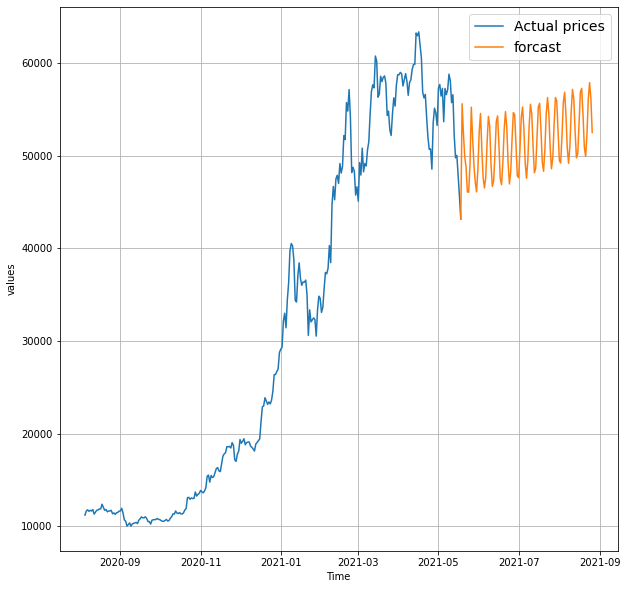

In [ ]:
# Plotting the forcasts
plt.figure(figsize=(10,10))
plot_time_series(bitcoin_prices.index, prices, start=2500, label="Actual prices", format="-")
plot_time_series(next_time_steps, future_forcast, label="forcast", format="-")

In [ ]:
### Comparing all models
model_results = pd.DataFrame({"naive_model": naive_results,
                              "model_1_dense_w7_h1": model_1_results,
                              "model_2_dense_w30_h1": model_2_results,
                              "model_3_dense_w30_h7": model_3_results,
                              "model_4_CONV1D": model_4_results,
                              "model_5_LSTM": model_5_results,
                              "model_6_multivariate": model_6_results,
                              "model_7_NBEATS": model_7_results,
                              "model_8_ensemble": ensemble_results}).T
model_results.head(10)

In [ ]:
model_results[["mae"]].sort_values(by="mae").plot(figsize=(10, 7), kind="bar");